In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import math
from statsmodels.stats import diagnostic
import statsmodels.stats as st
from scipy import stats
from itertools import combinations
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
import ast
from collections import Counter
import statsmodels.regression.recursive_ls as rls

from director_scrap import director_scrap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
#Function used for one-hot encoding of different values
def contains_(str_, contenant):
    try:
        dict_ = ast.literal_eval(str_)
        return contenant in dict_.values()
    except (ValueError, SyntaxError):
        # In case the string is not a proper dictionary format, we return False
        return False

# Load the data

In [87]:
df_usa = pd.read_table('data/data_usa.tsv')
df_usa.head(1)

,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_rating,Movie_producer,Movie_composer,Movie_director,Movie_writer,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release
0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0


# Top six most popular languages

In [88]:
str_languages = df_usa['Movie_languages'].apply(ast.literal_eval).tolist()
lang = [ [ i for i in item.values() ] for item in str_languages ]
lang_flat = [element for sublist in lang for element in sublist]

lang_counts = Counter(lang_flat)
top_lang = lang_counts.most_common(6)
print(top_lang)

[('English Language', 86462), ('Spanish Language', 5324), ('French Language', 4781), ('German Language', 2845), ('Italian Language', 2720), ('Russian Language', 2058)]


In [89]:
# 6 most spoken languages according to our analysis above
languages = ['English Language', 'Spanish Language', 'French Language', 
             'German Language', 'Italian Language', 'Russian Language']
    
for i in range(len(languages)):
    language = languages[i]
    df_usa[language] = df_usa['Movie_languages'].apply(lambda x: contains_(x, language))

In [90]:
df_usa[languages].head()

,English Language,Spanish Language,French Language,German Language,Italian Language,Russian Language
0,True,False,False,False,False,False
1,True,False,False,False,False,False
2,True,False,False,False,False,False
3,True,False,False,False,False,False
4,True,False,False,False,False,False


# Top ten most popular genres

In [91]:
str_genres = df_usa['Movie_genres'].apply(ast.literal_eval).tolist()
genres = [ [ i for i in item.values() ] for item in str_genres ]
genres_flat = [element for sublist in genres for element in sublist]

genre_counts = Counter(genres_flat)
top_genres = genre_counts.most_common(10)
print(top_genres)

[('Drama', 45045), ('Comedy', 38689), ('Thriller', 22666), ('Romance Film', 21747), ('Action', 21047), ('Action/Adventure', 16193), ('Adventure', 14658), ('Crime Fiction', 14509), ('Family Film', 11532), ('Indie', 11264)]


In [92]:
# 10 most popular genres according to our analysis above
genres = ['Drama', 'Comedy', 'Thriller', 'Romance Film', 'Action', 'Adventure', 'Crime Fiction', 
             'Family Film', 'Indie']
    
for i in range(len(genres)):
    genre = genres[i]
    df_usa[genre] = df_usa['Movie_genres'].apply(lambda x: contains_(x, genre))

In [93]:
df_usa[genres].head()

,Drama,Comedy,Thriller,Romance Film,Action,Adventure,Crime Fiction,Family Film,Indie
0,False,False,True,False,True,True,False,False,False
1,False,False,True,False,True,True,False,False,False
2,False,False,True,False,True,True,False,False,False
3,False,False,True,False,True,True,False,False,False
4,False,False,True,False,True,True,False,False,False


In [94]:
df_usa['Actor_name'] = df_usa['Actor_name'].astype(str)

# Group by 'Movie_name' and aggregate 'Actor_name' into lists
actor_pairs = df_usa.groupby('Movie_name')['Actor_name'].apply(list)

# For each movie, create all possible pairs of actors without duplication
actor_pairs = actor_pairs.apply(lambda x: list(combinations(sorted(set(x)), 2)))

# Flatten the list of actor pairs into a new dataframe and associate with the movie name
actor_pair_list = [(movie, *pair) for movie, pairs in actor_pairs.items() for pair in pairs]
df_actor_pairs = pd.DataFrame(actor_pair_list, columns=['Movie_name', 'Actor_1', 'Actor_2'])

In [95]:
df_actor_pairs.head(1)

,Movie_name,Actor_1,Actor_2
0,'Til There Was You,Alice Drummond,Christine Ebersole


In [97]:
df_usa.columns

Index(['Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime',
       'Movie_languages', 'Movie_countries', 'Movie_genres', 'Movie_rating',
       'Movie_producer', 'Movie_composer', 'Movie_director', 'Movie_writer',
       'Char_name', 'Actor_birth', 'Actor_gender', 'Actor_height',
       'Actor_ethnicity', 'Actor_name', 'Actor_age_release',
       'English Language', 'Spanish Language', 'French Language',
       'German Language', 'Italian Language', 'Russian Language', 'Drama',
       'Comedy', 'Thriller', 'Romance Film', 'Action', 'Adventure',
       'Crime Fiction', 'Family Film', 'Indie'],
      dtype='object')

In [118]:
df = df_actor_pairs.merge(df_usa, on='Movie_name', how='inner')
df = df.drop_duplicates(subset=['Movie_name', 'Actor_1', 'Actor_2'])
df = df.drop(['Movie_languages', 'Movie_countries', 'Movie_genres', 'Movie_producer', 
             'Movie_composer', 'Movie_director', 'Movie_writer', 'Char_name', 'Actor_age_release', 
             'Actor_ethnicity', 'Actor_name', 'Actor_birth', 'Actor_height', 'Actor_gender'], axis=1)
df.head()

,Movie_name,Actor_1,Actor_2,Movie_release,Movie_revenue,Movie_runtime,Movie_rating,English Language,Spanish Language,French Language,...,Russian Language,Drama,Comedy,Thriller,Romance Film,Action,Adventure,Crime Fiction,Family Film,Indie
0,'Til There Was You,Alice Drummond,Christine Ebersole,1997.0,3525125.0,114.0,4.8,True,False,False,...,False,False,True,False,True,False,False,False,False,False
11,'Til There Was You,Alice Drummond,Craig Bierko,1997.0,3525125.0,114.0,4.8,True,False,False,...,False,False,True,False,True,False,False,False,False,False
22,'Til There Was You,Alice Drummond,Dylan McDermott,1997.0,3525125.0,114.0,4.8,True,False,False,...,False,False,True,False,True,False,False,False,False,False
33,'Til There Was You,Alice Drummond,Jeanne Tripplehorn,1997.0,3525125.0,114.0,4.8,True,False,False,...,False,False,True,False,True,False,False,False,False,False
44,'Til There Was You,Alice Drummond,Jennifer Aniston,1997.0,3525125.0,114.0,4.8,True,False,False,...,False,False,True,False,True,False,False,False,False,False


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668116 entries, 0 to 14647378
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Movie_name        668116 non-null  object 
 1   Actor_1           668116 non-null  object 
 2   Actor_2           668116 non-null  object 
 3   Movie_release     668098 non-null  float64
 4   Movie_revenue     668116 non-null  float64
 5   Movie_runtime     666160 non-null  float64
 6   Movie_rating      572601 non-null  float64
 7   English Language  668116 non-null  bool   
 8   Spanish Language  668116 non-null  bool   
 9   French Language   668116 non-null  bool   
 10  German Language   668116 non-null  bool   
 11  Italian Language  668116 non-null  bool   
 12  Russian Language  668116 non-null  bool   
 13  Drama             668116 non-null  bool   
 14  Comedy            668116 non-null  bool   
 15  Thriller          668116 non-null  bool   
 16  Romance Film      66811

In [120]:
def z_score(df, columns):
    df_z = df.copy()
    for item in columns:
        df_z[item] = (df_z[item] - df_z[item].mean())/(df_z[item].std() + 1e-30)
    
    return df_z

In [121]:
df = z_score(df, ['Movie_release', 'Movie_revenue', 'Movie_rating'])
df.head(1)

,Movie_name,Actor_1,Actor_2,Movie_release,Movie_revenue,Movie_runtime,Movie_rating,English Language,Spanish Language,French Language,...,Russian Language,Drama,Comedy,Thriller,Romance Film,Action,Adventure,Crime Fiction,Family Film,Indie
0,'Til There Was You,Alice Drummond,Christine Ebersole,0.127273,-0.490834,114.0,-1.71228,True,False,False,...,False,False,True,False,True,False,False,False,False,False


<Axes: >

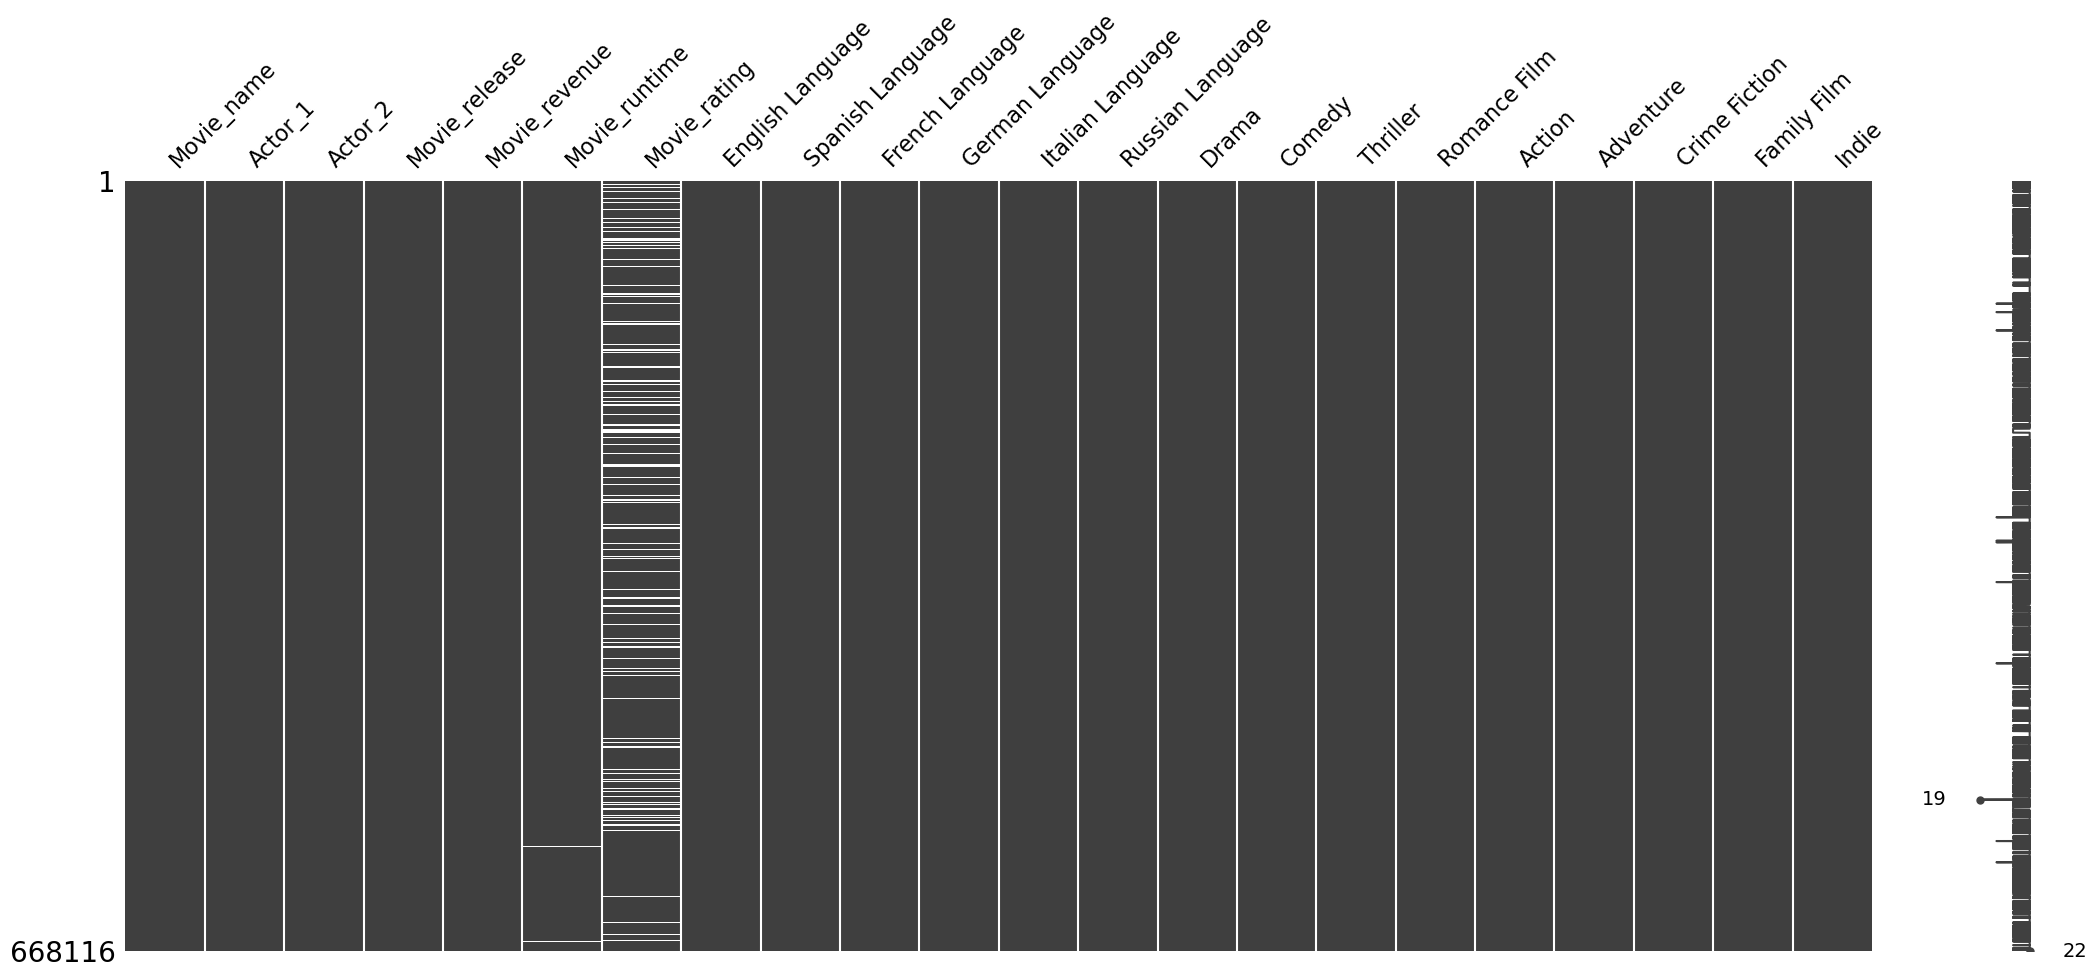

In [122]:
msno.matrix(df)

In [123]:
df = df.dropna()

<Axes: >

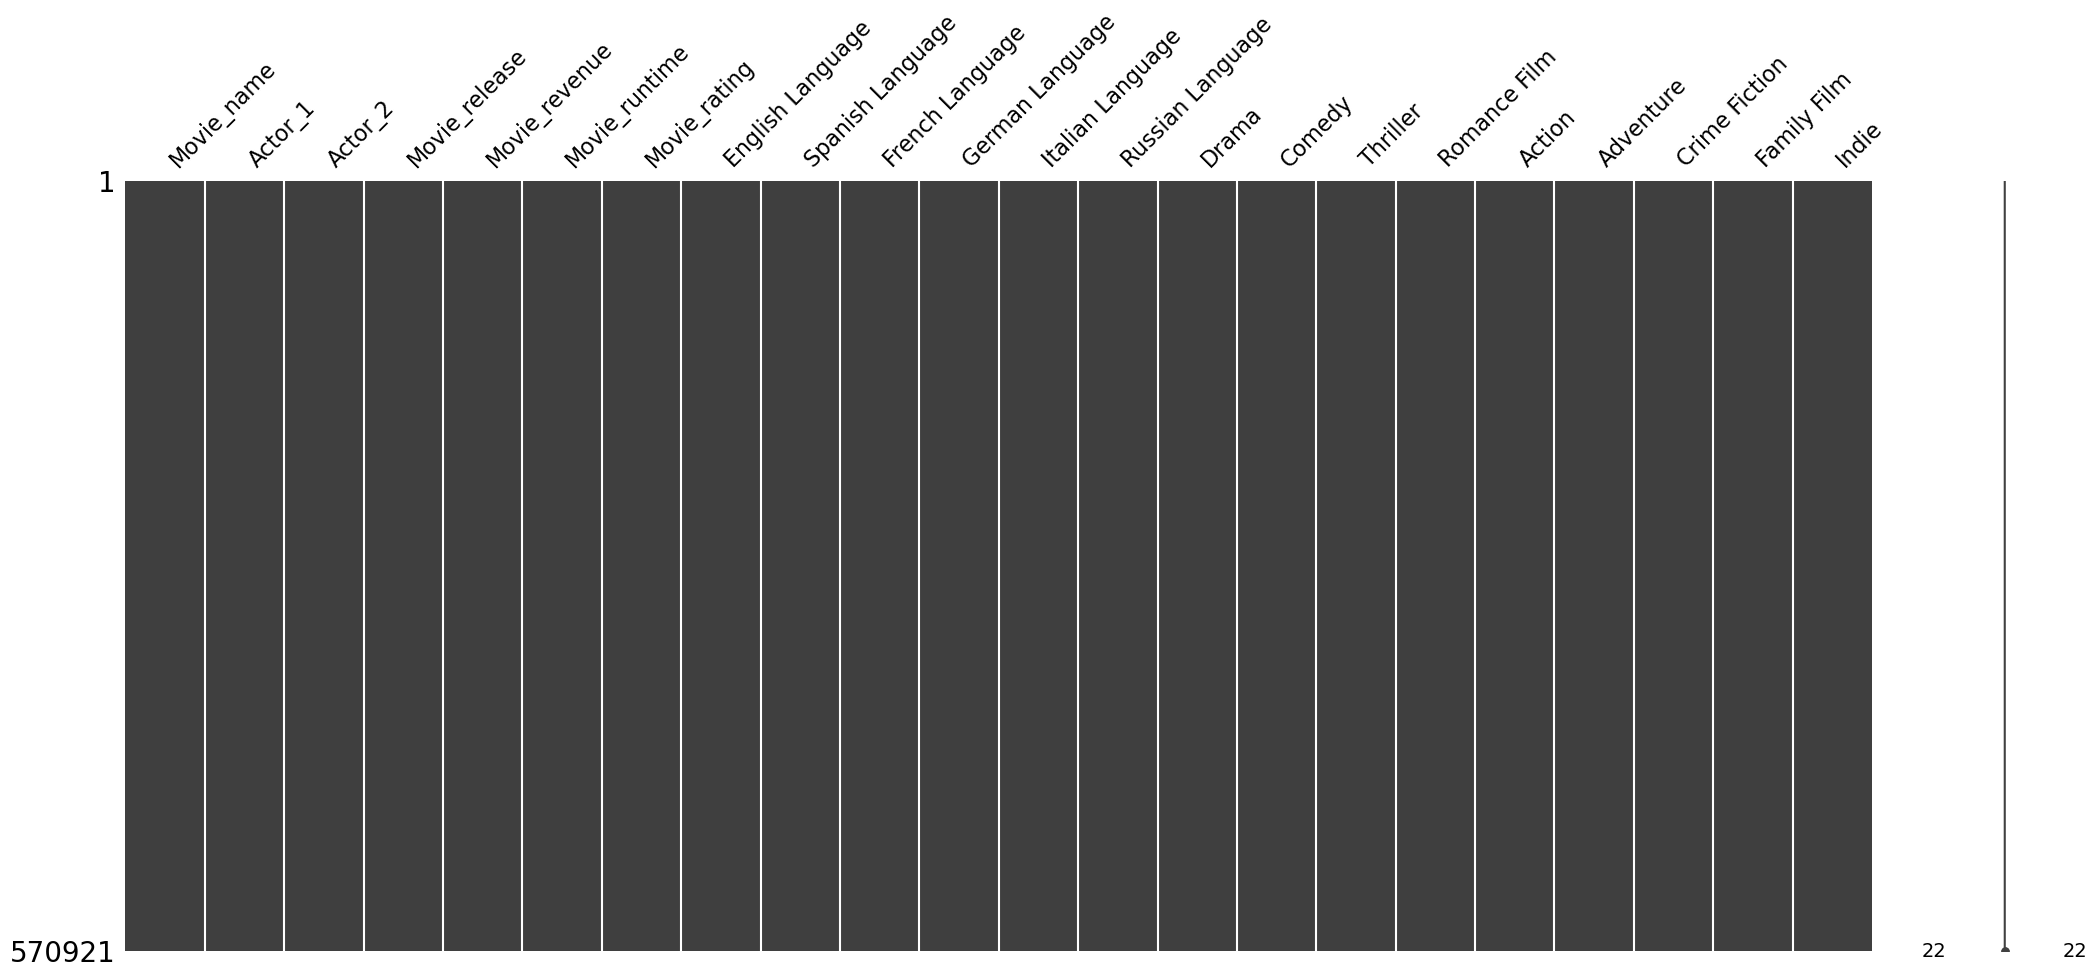

In [124]:
msno.matrix(df)

In [132]:
df = df.rename(columns={'English Language': 'eng', 'Spanish Language': 'spain', 'French Language': 'fr', 
                       'German Language': 'ger', 'Italian Language': 'ita', 'Russian Language': 'rus', 
                       'Romance Film': 'Romance', 'Crime Fiction': 'Crime_fiction', 
                       'Family Film': 'Family'})

In [150]:
mod = smf.ols(formula="Movie_revenue ~  Movie_release + Movie_rating + C(eng) \
              + C(spain) + C(fr) + C(ger) + C(ita) + C(rus) + C(Drama) + C(Comedy) \
              + C(Thriller) + C(Romance) + C(Action) + C(Adventure) + C(Crime_fiction) \
              + C(Family) + C(Indie)", data=df)

res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score'] = res.predict()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          Movie_revenue   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                 1.501e+04
Date:                Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:54:33   Log-Likelihood:            -6.5437e+05
No. Observations:              570921   AIC:                         1.309e+06
Df Residuals:                  570903   BIC:                         1.309e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 570921 entries, 0 to 14647378
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Movie_name        570921 non-null  object 
 1   Actor_1           570921 non-null  object 
 2   Actor_2           570921 non-null  object 
 3   Movie_release     570921 non-null  float64
 4   Movie_revenue     570921 non-null  float64
 5   Movie_runtime     570921 non-null  float64
 6   Movie_rating      570921 non-null  float64
 7   eng               570921 non-null  bool   
 8   spain             570921 non-null  bool   
 9   fr                570921 non-null  bool   
 10  ger               570921 non-null  bool   
 11  ita               570921 non-null  bool   
 12  rus               570921 non-null  bool   
 13  Drama             570921 non-null  bool   
 14  Comedy            570921 non-null  bool   
 15  Thriller          570921 non-null  bool   
 16  Romance           57092